In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
import seaborn as sns
from sklearn import model_selection

In [2]:
#Always call fit on the estimator before invoking this method. 
def importances(model, col_array, title): 
    # Calculate the feature ranking - Top 10 
    importances = model.feature_importances_ 
    indices = np.argsort(importances)[::-1]
    print("Top Important Features\n", title)
    #for f in range(col_array.shape[1]-1): 
    for f in range(10): 
        print("%d. %s (%f)" % (f + 1, col_array.columns[indices[f]], importances[indices[f]]))
        
    #Mean Feature Importance 
    print("\nMean Feature Importance ", np.mean(importances))
    #Plot the feature importances of the forest 
    indices=indices[:10]
    plt.figure()
    plt.title(title+" Top 10 Feature importances")
    plt.bar(range(10), importances[indices], color="gr", align="center")
    plt.xticks(range(10), col_array.columns[indices], fontsize=8, rotation=90)
    plt.xlim([-1, 10])
    plt.show()

### Load train and test data

In [3]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [4]:
df_mess_train.head(10)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216
5,573c0cd0f0fe6e735a699b93,8474,473953.0,2.0,-100.000000,1.463553e+12,39.732045,-104.973651
6,573c1272f0fe6e735a6cb8bd,1859,476512.0,1.0,-123.333333,1.463555e+12,39.704887,-105.016392
7,573c1272f0fe6e735a6cb8bd,2605,476512.0,1.0,-129.666667,1.463555e+12,39.612745,-105.008827
8,573c1272f0fe6e735a6cb8bd,3025,476512.0,1.0,-123.666667,1.463555e+12,39.654682,-105.043685
9,573c1272f0fe6e735a6cb8bd,8082,476512.0,1.0,-133.000000,1.463555e+12,39.495225,-105.053109


In [5]:
pos_train.head(10)

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940
5,39.730417,-104.968940
6,39.693102,-105.006995
7,39.693102,-105.006995
8,39.693102,-105.006995
9,39.693102,-105.006995


In [6]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [7]:
len(listOfBs)

259

In [8]:
# Add Latitude and Longitude to the initial dataset
df_mess_pos = df_mess_train.copy()
df_mess_pos[['lat', 'lng']] = pos_train
df_mess_pos.head(10)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940
5,573c0cd0f0fe6e735a699b93,8474,473953.0,2.0,-100.000000,1.463553e+12,39.732045,-104.973651,39.730417,-104.968940
6,573c1272f0fe6e735a6cb8bd,1859,476512.0,1.0,-123.333333,1.463555e+12,39.704887,-105.016392,39.693102,-105.006995
7,573c1272f0fe6e735a6cb8bd,2605,476512.0,1.0,-129.666667,1.463555e+12,39.612745,-105.008827,39.693102,-105.006995
8,573c1272f0fe6e735a6cb8bd,3025,476512.0,1.0,-123.666667,1.463555e+12,39.654682,-105.043685,39.693102,-105.006995
9,573c1272f0fe6e735a6cb8bd,8082,476512.0,1.0,-133.000000,1.463555e+12,39.495225,-105.053109,39.693102,-105.006995


In [16]:
# Select all the outlier stations
outliers_bsid = np.unique(df_mess_pos[df_mess_pos['bs_lat'] >= 50]['bsid'])
print(outliers_bsid.shape[0], "stations are ouliers:\n", outliers_bsid)
outliers_bsid_df = pd.DataFrame(outliers_bsid)
outliers_bsid_df.columns = ['bsid']

27 stations are ouliers:
 [ 1092  1594  1661  1743  1772  1796  1854  2293  2707  2943  4123  4129
  4156  4959  4987  4993  7248  8355  8449  8451  8560  9784 10151 10162
 10999 11007 11951]


In [24]:
df_mess_pos_sort = df_mess_pos.copy()
df_mess_pos_sort = df_mess_pos_sort.sort_values(by='bsid', ascending=True)

In [25]:
# Merge splited devices with full dataset
# Train
df_test_merged = df_mess_pos_sort.merge(outliers_bsid_df, on='bsid')
df_test_merged.head(10)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,582c8fa4cf554f7e3aad4ea6,1092,476829.0,1.0,-141.000000,1.479315e+12,64.3,-68.5,39.706525,-105.018891
1,583d9df7cf554f7e3a38e3c0,1092,476829.0,2.0,-140.000000,1.480433e+12,64.3,-68.5,39.702498,-105.018795
2,582c888ecf554f7e3aa7932b,1092,476829.0,1.0,-141.000000,1.479314e+12,64.3,-68.5,39.704462,-105.018355
3,583d7c12cf554f7e3a1b896a,1092,476829.0,0.5,-141.000000,1.480424e+12,64.3,-68.5,39.706376,-105.019207
4,583d79cae541cd03e7baf244,1092,476829.0,1.0,-140.666667,1.480424e+12,64.3,-68.5,39.704704,-105.020228
5,583d9911cf554f7e3a34b75b,1092,476829.0,0.0,-140.000000,1.480432e+12,64.3,-68.5,39.706583,-105.018979
6,583d8f7d12f1434b9c935604,1092,476829.0,1.0,-141.000000,1.480429e+12,64.3,-68.5,39.706873,-105.018876
7,582c8619e541cd03e7437b1c,1092,476829.0,1.5,-140.000000,1.479313e+12,64.3,-68.5,39.706375,-105.018765
8,582c7ee4e541cd03e73d65d9,1092,476829.0,1.5,-141.000000,1.479311e+12,64.3,-68.5,39.706803,-105.018901
9,582c948e12f1434b9c1cd22f,1092,476829.0,1.0,-140.000000,1.479317e+12,64.3,-68.5,39.706741,-105.018975


In [26]:
df_test_merged.shape

(4389, 10)

In [31]:
all_train_bsid = np.unique(df_mess_pos['bsid'])

(251,)

In [29]:
df_train_merged = df_mess_pos_sort.merge(outliers_bsid_df, on='bsid', how='outer')
df_train_merged.head(10)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,5822597ecf554f7e3a4d60a2,879,477201.0,1.0,-132.666667,1.478646e+12,39.739013,-105.392793,39.876481,-105.262660
1,5822df26cf554f7e3aa2e56e,911,474192.0,1.0,-122.000000,1.478680e+12,42.324279,-107.159505,42.452279,-107.050011
2,5822df26cf554f7e3aa2e56e,921,474192.0,0.0,-130.000000,1.478680e+12,42.131222,-107.008741,42.452279,-107.050011
3,57aae6ad12f1434591dc023d,944,476256.0,1.0,-133.000000,1.470818e+12,41.424900,-106.143919,41.053086,-105.914665
4,5835da9ce541cd03e70b29a7,944,476889.0,2.0,-137.000000,1.479924e+12,41.424900,-106.143919,40.840967,-105.911902
5,58302f58e541cd03e7edeb7b,944,476896.0,1.0,-122.000000,1.479553e+12,41.424900,-106.143919,41.279237,-106.115996
6,57c55354cf554f465aa9941f,980,476598.0,0.5,-128.000000,1.472550e+12,38.997730,-104.684275,39.099739,-104.574992
7,57934f3fcf554f22c13640ce,980,476598.0,1.0,-120.000000,1.469272e+12,38.997730,-104.684275,39.094773,-104.631262
8,57a02ecb12f1434591e4a066,980,476600.0,1.5,-126.500000,1.470116e+12,38.997730,-104.684275,39.157969,-104.702613
9,57aed618e541cd77a05c105a,980,476598.0,1.0,-135.000000,1.471076e+12,38.997730,-104.684275,39.043789,-104.466839


In [30]:
df_train_merged.shape

(39250, 10)

In [20]:
new_train_pos = df_mess_pos.copy()
columns = ['bsid', 'messid', 'did', 'bs_lat', 'bs_lng']
new_train_pos.drop(columns, inplace=True, axis=1)
y_bs_lat = df_mess_pos['bs_lat']
y_bs_lng = df_mess_pos['bs_lng']

In [9]:
df_mess_pos.shape

(39250, 10)

In [27]:
# Sort train dataset by device
df_mess_pos_sort = df_mess_pos.copy()
df_mess_pos_sort = df_mess_pos_sort.sort_values(by='did', ascending=True)

In [28]:
# Create the devices list
did_list_train = np.unique(df_mess_train['did'])
did_list_df = pd.DataFrame(did_list_train)
did_list_df.columns = ['did']

### Split training set into new train and validation subsets by device

In [119]:
# Split devices into train and validation subsets, shuffle=True
did_list_train, did_list_test = model_selection.train_test_split(did_list_df, test_size = 0.25, shuffle=True)
did_list_train = did_list_train.sort_values(by='did', ascending=True)
did_list_test = did_list_test.sort_values(by='did', ascending=True)
print("did_list_train size:", did_list_train.shape[0])
print("did_list_test size:", did_list_test.shape[0])

did_list_train size: 84
did_list_test size: 29


In [120]:
# Merge splited devices with full dataset
# Train
df_train_merged = df_mess_pos_sort.merge(did_list_train, on='did')
df_train_merged.head(10)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,582ae1d712f1434b9ccad421,2189,473288.0,1.0,-127.000000,1.479205e+12,39.817654,-105.050984,39.774984,-105.039440
1,582bde7bcf554f7e3a1a7720,3848,473288.0,1.0,-128.666667,1.479270e+12,43.614138,-103.723449,39.774541,-105.039339
2,582bde7bcf554f7e3a1a7720,3501,473288.0,1.5,-136.000000,1.479270e+12,43.639226,-103.761023,39.774541,-105.039339
3,582bde7bcf554f7e3a1a7720,2803,473288.0,1.5,-139.500000,1.479270e+12,43.657077,-103.756890,39.774541,-105.039339
4,582bde7bcf554f7e3a1a7720,2800,473288.0,1.5,-138.000000,1.479270e+12,43.631515,-103.765896,39.774541,-105.039339
5,582bd926e541cd03e7b48c36,3933,473288.0,2.0,-132.000000,1.479269e+12,43.671528,-103.815822,39.774541,-105.039339
6,582bd926e541cd03e7b48c36,3848,473288.0,1.0,-128.000000,1.479269e+12,43.614138,-103.723449,39.774541,-105.039339
7,582bd926e541cd03e7b48c36,3501,473288.0,1.0,-136.000000,1.479269e+12,43.639226,-103.761023,39.774541,-105.039339
8,582bd926e541cd03e7b48c36,2803,473288.0,0.0,-135.000000,1.479269e+12,43.657077,-103.756890,39.774541,-105.039339
9,582bd926e541cd03e7b48c36,2800,473288.0,0.0,-137.000000,1.479269e+12,43.631515,-103.765896,39.774541,-105.039339


In [121]:
# Test
df_test_merged = df_mess_pos_sort.merge(did_list_test, on='did')
df_test_merged.head(10)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,57599f09864fce568932b7f5,1859,473805.0,0.0,-129.000000,1.465491e+12,39.704887,-105.016392,39.705300,-104.973442
1,57599f09864fce568932b7f5,1872,473805.0,0.0,-133.000000,1.465491e+12,39.823856,-105.239120,39.705300,-104.973442
2,57599f09864fce568932b7f5,2617,473805.0,1.0,-141.333333,1.465491e+12,39.779908,-105.062479,39.705300,-104.973442
3,57599f09864fce568932b7f5,3548,473805.0,2.0,-134.000000,1.465491e+12,39.744848,-105.010048,39.705300,-104.973442
4,57599f09864fce568932b7f5,3846,473805.0,2.0,-135.000000,1.465491e+12,39.753719,-104.998668,39.705300,-104.973442
5,57599f09864fce568932b7f5,8474,473805.0,1.0,-135.000000,1.465491e+12,39.732045,-104.973651,39.705300,-104.973442
6,5759996af0fe6e0c9f8dc13c,3571,473805.0,0.0,-137.000000,1.465490e+12,39.681876,-104.986868,39.678571,-104.985277
7,57590c943e952e04b301a3f4,3571,473805.0,1.0,-132.666667,1.465454e+12,39.681876,-104.986868,39.670385,-104.990062
8,57590c943e952e04b301a3f4,3025,473805.0,0.5,-126.500000,1.465454e+12,39.654682,-105.043685,39.670385,-104.990062
9,57590c943e952e04b301a3f4,2605,473805.0,2.0,-140.000000,1.465454e+12,39.612745,-105.008827,39.670385,-104.990062


In [122]:
df_train_merged.shape

(24108, 10)

In [123]:
df_test_merged.shape

(15142, 10)

### Save splitted data set to CSV

In [134]:
# Write splitted data set to CSV
my_train_file = 'my_train_merged.csv'
df_train_merged.to_csv(my_train_file, sep=',', index=False)
my_test_file = 'my_test_merged.csv'
df_test_merged.to_csv(my_test_file, sep=',', index=False)

### Load splitted data from CSV

In [136]:
# Load data
my_train_file = 'my_train_merged.csv'
df_train_merged = pd.read_csv(my_train_file, sep = ',')
my_test_file = 'my_test_merged.csv'
df_test_merged = pd.read_csv(my_test_file, sep = ',')

### Feature Matrix construction

In [38]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx,df_mess_bs_group.get_group(key)['bsid']] = 1
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

In [39]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [137]:
# Generate train features matrix
df_feat, id_list_train = feat_mat_const(df_train_merged, listOfBs)
df_feat.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
df_feat.shape

(4418, 259)

In [139]:
new_pos_train = df_train_merged[['lat', 'lng']]
gr_truth_lat_train, gr_truth_lng_train = ground_truth_const(df_train_merged, new_pos_train)
gr_truth_lat_train.shape

(4418,)

In [140]:
new_pos_test = df_test_merged[['lat', 'lng']]
gr_truth_lat_test, gr_truth_lng_test = ground_truth_const(df_test_merged, new_pos_test)
gr_truth_lat_test.shape

(1650,)

In [141]:
# Generate test features matrix
df_feat_test, id_list_test = feat_mat_const(df_test_merged, listOfBs)
df_feat_test.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model and Prediction

In [129]:
def regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, df_test, gr_truth_lat_test, gr_truth_lng_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    from sklearn import linear_model

    X_train = np.array(df_feat);
    X_test = np.array(df_test);
    #reg = linear_model.LinearRegression()
    #reg = RandomForestRegressor(random_state=2792)
    reg = ExtraTreesRegressor()

    reg.fit(X_train, gr_truth_lat_train);
    y_pred_lat = reg.predict(df_test) 
    print("Latitude Accuracy :", reg.score(X_test, gr_truth_lat_test))
    importances(reg, df_feat, "Latitude Features utilisée")

    reg.fit(X_train, gr_truth_lng_train);
    y_pred_lng = reg.predict(df_test) 
    print("Longitude Accuracy :", reg.score(X_test, gr_truth_lng_test))
    importances(reg, df_feat, "Longitude Features utilisée")
    
    return y_pred_lat, y_pred_lng


**Make regressor and prediction using the validation test set**

Latitude Accuracy : 0.49969684423805183
Top Important Features
 Latitude Features utilisée
1. 4790 (0.621018)
2. 3613 (0.073476)
3. 1828 (0.060991)
4. 1526 (0.035367)
5. 1534 (0.027699)
6. 3629 (0.024533)
7. 2831 (0.022457)
8. 7807 (0.017674)
9. 1852 (0.009137)
10. 7490 (0.008842)

Mean Feature Importance  0.0038610038610038607


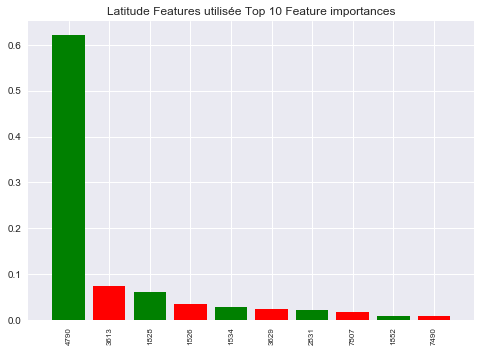

Longitude Accuracy : 0.369534649900607
Top Important Features
 Longitude Features utilisée
1. 4790 (0.643102)
2. 3613 (0.074047)
3. 1828 (0.056590)
4. 2831 (0.025410)
5. 1534 (0.024111)
6. 7490 (0.021757)
7. 3629 (0.020204)
8. 7807 (0.016805)
9. 1526 (0.014505)
10. 8392 (0.008009)

Mean Feature Importance  0.003861003861003861


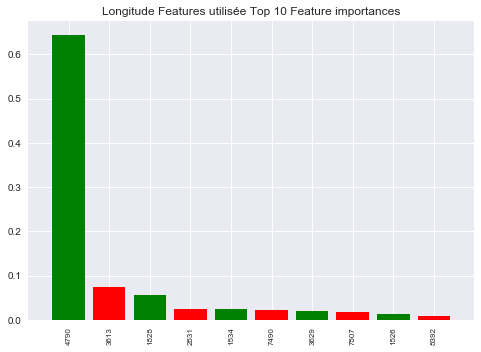

In [142]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, 
                                               df_feat_test, gr_truth_lat_test, gr_truth_lng_test)

### Cross validation

In [18]:
from sklearn.model_selection import cross_val_predict

In [19]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
y_pred_cv_lng = cross_val_predict(reg, df_feat, ground_truth_lng, cv=10)
y_pred_cv_lat = cross_val_predict(reg, df_feat, ground_truth_lat, cv=10)

### Evaluate result

In [58]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [59]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

**Errors calculation**

In [143]:
err_vec = Eval_geoloc(gr_truth_lat_test , gr_truth_lng_test, y_pred_lat, y_pred_lng)

**Plot error distribution**

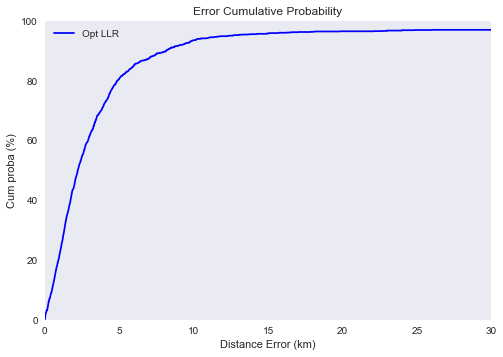

In [144]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

**Error criterion**

In [145]:
# Error criterion
np.percentile(err_vec, 80)

4890.162205767973

### Construct test prediction

In [26]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [27]:
df_feat_test, id_list_test = feat_mat_const(df_mess_test, listOfBs)

In [28]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

In [29]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

In [31]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [32]:
test_res.head()

,lat,lng,messid
0,39.772618,-105.050029,573be2503e952e191262c351
1,39.775792,-105.063594,573c05f83e952e1912758013
2,39.678112,-105.012249,573c0796f0fe6e735a66deb3
3,39.773777,-105.037761,573c08d2864fce1a9a0563bc
4,39.678112,-105.012249,573c08ff864fce1a9a0579b0
